# Modelo de Optimización Lineal Entera Mixta (MILP)

## Definición del Problema

Se desea minimizar el costo total de construcción y operación de plantas de generación eléctrica mientras se satisface la demanda energética y se cumplen las restricciones ambientales.

### Datos del Problema

- **Tipos de Plantas:**
  - Térmica (T)
  - Hidroeléctrica (H)
  - Renovable (R)

- **Costos:**
  - **Costo de construcción:**  
    - T: 1,000,000 USD  
    - H: 2,000,000 USD  
    - R: 800,000 USD  
  
  - **Costo de generación:**  
    - T: 50 USD/MW  
    - H: 30 USD/MW  
    - R: 20 USD/MW  

- **Emisiones de CO₂:**
  - T: 0.8 ton/MW  
  - H, R: 0 ton/MW  

- **Generación mínima y máxima por planta:**
  - T: 50 ≤ g_Ti ≤ 200
  - H: 100 ≤ g_Hj ≤ 300
  - R: 20 ≤ g_Rk ≤ 150

- **Restricciones:**
  - Demanda total: 1000 MW.
  - Límite de CO₂: 500 toneladas.
  - Máximo de plantas por tipo: 10.

## Formulación Matemática

### Variables de Decisión

**Variables enteras:**
- \( x_T, x_H, x_R \in \mathbb{Z}^+ \)  
  Número de plantas a construir de cada tipo (entre 0 y 10).

**Variables continuas:**
- \( g_{Ti}, g_{Hj}, g_{Rk} \geq 0 \)  
  Generación de cada planta térmica, hidroeléctrica y renovable.

### Función Objetivo

Minimizar el costo total de construcción y generación:

\[
\min Z = \sum_{i=1}^{x_T} (1,000,000) + \sum_{j=1}^{x_H} (2,000,000) + \sum_{k=1}^{x_R} (800,000) + \sum_{i=1}^{x_T} (50 g_{Ti}) + \sum_{j=1}^{x_H} (30 g_{Hj}) + \sum_{k=1}^{x_R} (20 g_{Rk}).
\]

### Restricciones

**1. Satisfacción de la demanda energética:**

\[
\sum_{i=1}^{x_T} g_{Ti} + \sum_{j=1}^{x_H} g_{Hj} + \sum_{k=1}^{x_R} g_{Rk} \geq 1000.
\]

**2. Límites de generación por planta:**

\[
50 \leq g_{Ti} \leq 200, \quad \forall i = 1, \dots, x_T,
\]
\[
100 \leq g_{Hj} \leq 300, \quad \forall j = 1, \dots, x_H,
\]
\[
20 \leq g_{Rk} \leq 150, \quad \forall k = 1, \dots, x_R.
\]

**3. Restricción de emisiones de CO₂:**

\[
\sum_{i=1}^{x_T} 0.8 g_{Ti} \leq 500.
\]

**4. Límite en la cantidad de plantas:**

\[
0 \leq x_T, x_H, x_R \leq 10, \quad x_T, x_H, x_R \in \mathbb{Z}^+.
\]

## Estrategia de Resolución

El problema se resolverá en tres fases:

1. **Fase 1:** Resolver el problema relajado con el **método Simplex**.
2. **Fase 2:** Agregar restricciones enteras y resolver con **Ramificación y Acotación (Branch & Bound)**.
3. **Fase 3:** Incorporar **Planos Cortantes (cortes de Gomory)** para fortalecer el modelo.



## Fase 1

Estado de la solución: Optimal
Costo total: 5163750.0
Plantas térmicas: 3.125
Plantas hidroeléctricas: 0.0
Plantas renovables: 2.5
Generación térmica: 625.0
Generación hidroeléctrica: 0.0
Generación renovable: 375.0


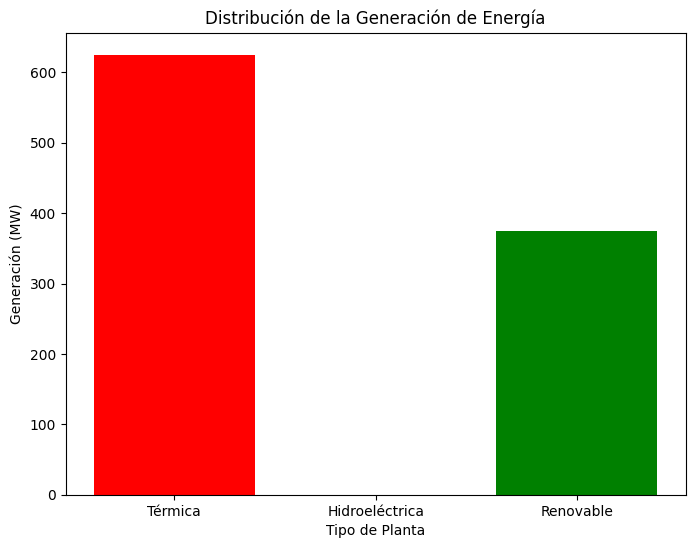

In [1]:
import pulp
import matplotlib.pyplot as plt
import numpy as np

# Definir el problema
problem = pulp.LpProblem("LP_PowerPlant_Optimization", pulp.LpMinimize)

# Variables continuas para la cantidad de plantas
x_T = pulp.LpVariable("x_T", lowBound=0, upBound=10, cat='Continuous')
x_H = pulp.LpVariable("x_H", lowBound=0, upBound=10, cat='Continuous')
x_R = pulp.LpVariable("x_R", lowBound=0, upBound=10, cat='Continuous')

# Variables continuas para la generación por planta
G_T = pulp.LpVariable("G_T", lowBound=0)
G_H = pulp.LpVariable("G_H", lowBound=0)
G_R = pulp.LpVariable("G_R", lowBound=0)

# Restringir G_T, G_H, G_R según las plantas
problem += G_T >= 50 * x_T
problem += G_T <= 200 * x_T
problem += G_H >= 100 * x_H
problem += G_H <= 300 * x_H
problem += G_R >= 20 * x_R
problem += G_R <= 150 * x_R

# Función objetivo: Minimizar costos totales
problem += (
    x_T * 1_000_000 + x_H * 2_000_000 + x_R * 800_000 +
    50 * G_T + 30 * G_H + 20 * G_R
), "Total_Cost"

# Restricción de demanda
problem += (G_T + G_H + G_R >= 1000), "Demand"

# Restricción de emisiones de CO2
problem += (0.8 * G_T <= 500), "CO2_Limit"

# Resolver el problema con Simplex
problem.solve()

# Imprimir resultados
print("Estado de la solución:", pulp.LpStatus[problem.status])
print("Costo total:", pulp.value(problem.objective))
print("Plantas térmicas:", pulp.value(x_T))
print("Plantas hidroeléctricas:", pulp.value(x_H))
print("Plantas renovables:", pulp.value(x_R))
print("Generación térmica:", pulp.value(G_T))
print("Generación hidroeléctrica:", pulp.value(G_H))
print("Generación renovable:", pulp.value(G_R))

# Visualización de la generación
labels = ["Térmica", "Hidroeléctrica", "Renovable"]
generacion = [pulp.value(G_T), pulp.value(G_H), pulp.value(G_R)]

plt.figure(figsize=(8, 6))
plt.bar(labels, generacion, color=['red', 'blue', 'green'])
plt.xlabel("Tipo de Planta")
plt.ylabel("Generación (MW)")
plt.title("Distribución de la Generación de Energía")
plt.show()


branch and bounds



📌 **Resultados Branch and Bound**
📉 Costo Óptimo: 5232000.0
🕒 Iteraciones: 15
⏳ Tiempo de ejecución: 0.2535 segundos
📊 Solución óptima encontrada: {'x_T': 2.0, 'x_H': 0.0, 'x_R': 4.0}


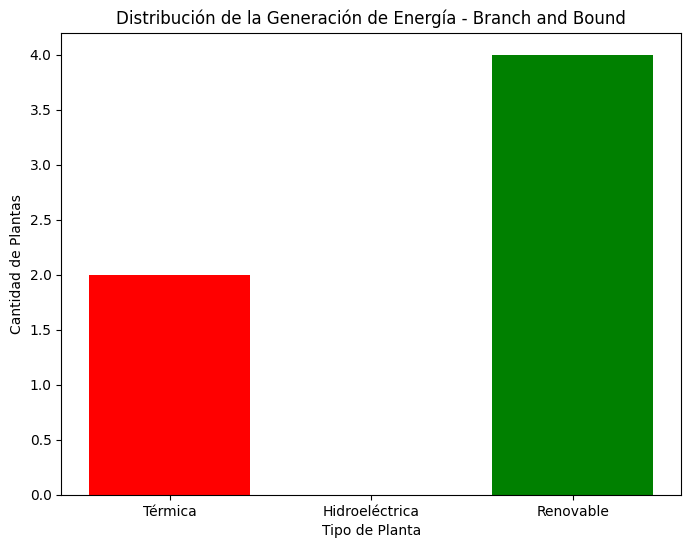

In [1]:
import pulp
import time
import pandas as pd
import matplotlib.pyplot as plt

def branch_and_bound(problem, vars_ent, max_iters=100):
    """ Implementación del método Branch and Bound """
    iteraciones = 0
    cola = [(problem, [])]  # Inicializar la cola con el problema original

    mejor_sol = None
    mejor_costo = float("inf")

    while cola and iteraciones < max_iters:
        iteraciones += 1
        nodo, ramas = cola.pop(0)

        # Resolver la relajación LP del nodo actual
        nodo.solve()

        if nodo.status != pulp.LpStatusOptimal:
            continue  # No hay solución óptima para este nodo

        # Obtener solución óptima relajada
        costo_actual = pulp.value(nodo.objective)
        valores_vars = {var.name: pulp.value(var) for var in vars_ent}

        # Si la solución es peor que la mejor encontrada, descartar
        if costo_actual >= mejor_costo:
            continue

        # Verificar si todas las variables enteras están en valores enteros
        if all(abs(val - int(val)) < 1e-6 for val in valores_vars.values()):
            mejor_sol = valores_vars
            mejor_costo = costo_actual
            continue  # No hay necesidad de seguir explorando

        # Seleccionar una variable no entera para bifurcar
        var_frac = next(var for var in vars_ent if abs(valores_vars[var.name] - int(valores_vars[var.name])) > 1e-6)

        # Crear dos nuevos subproblemas con restricciones adicionales
        nuevo_nodo1 = nodo.deepcopy()
        nuevo_nodo1 += var_frac <= int(valores_vars[var_frac.name])

        nuevo_nodo2 = nodo.deepcopy()
        nuevo_nodo2 += var_frac >= int(valores_vars[var_frac.name]) + 1

        cola.append((nuevo_nodo1, ramas + [f"{var_frac.name} <= {int(valores_vars[var_frac.name])}"]))
        cola.append((nuevo_nodo2, ramas + [f"{var_frac.name} >= {int(valores_vars[var_frac.name]) + 1}"]))

    return mejor_sol, mejor_costo, iteraciones


# ** Definir el problema inicial **
def crear_problema():
    problem = pulp.LpProblem("MILP_PowerPlant_Optimization", pulp.LpMinimize)

    x_T = pulp.LpVariable("x_T", lowBound=0, upBound=10, cat='Continuous')
    x_H = pulp.LpVariable("x_H", lowBound=0, upBound=10, cat='Continuous')
    x_R = pulp.LpVariable("x_R", lowBound=0, upBound=10, cat='Continuous')

    G_T = pulp.LpVariable("G_T", lowBound=0)
    G_H = pulp.LpVariable("G_H", lowBound=0)
    G_R = pulp.LpVariable("G_R", lowBound=0)

    problem += G_T >= 50 * x_T
    problem += G_T <= 200 * x_T
    problem += G_H >= 100 * x_H
    problem += G_H <= 300 * x_H
    problem += G_R >= 20 * x_R
    problem += G_R <= 150 * x_R

    problem += (x_T * 1_000_000 + x_H * 2_000_000 + x_R * 800_000 +
                50 * G_T + 30 * G_H + 20 * G_R), "Total_Cost"

    problem += (G_T + G_H + G_R >= 1000), "Demand"
    problem += (0.8 * G_T <= 500), "CO2_Limit"

    return problem, [x_T, x_H, x_R]


if __name__ == "__main__":
    problema, vars_ent = crear_problema()
    
    start_time = time.time()
    solucion, costo, iteraciones = branch_and_bound(problema, vars_ent)
    end_time = time.time()

    tiempo_total = end_time - start_time

    print("\n📌 **Resultados Branch and Bound**")
    print(f"📉 Costo Óptimo: {costo}")
    print(f"🕒 Iteraciones: {iteraciones}")
    print(f"⏳ Tiempo de ejecución: {tiempo_total:.4f} segundos")
    print(f"📊 Solución óptima encontrada: {solucion}")

    # ** Visualización de generación de energía **
    if solucion:
        etiquetas = ["Térmica", "Hidroeléctrica", "Renovable"]
        valores = [solucion["x_T"], solucion["x_H"], solucion["x_R"]]

        plt.figure(figsize=(8, 6))
        plt.bar(etiquetas, valores, color=['red', 'blue', 'green'])
        plt.xlabel("Tipo de Planta")
        plt.ylabel("Cantidad de Plantas")
        plt.title("Distribución de la Generación de Energía - Branch and Bound")
        plt.show()
